In [3]:
import paho.mqtt.client as mqtt
import threading
import os
import re
# import motionlocalizer.settings
import json
# import requests
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import xml.etree.ElementTree
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time as pythonTimer
import random
from random import randint
import scipy.stats as stats
from scipy.stats import multivariate_normal

simworldname = 'simulationWorld2.xml' #ENVIROMENT
groundtruth = 'AgentDetailedTasksFile.csv' #AGENT'S MOVEMENTS

my_map = [(0.0, 0.0), (0.0, 10.6), (6.6, 10.6), (6.6, 0.0)]
grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
distances = []

oracle = {}
oracle['time'] = []
oracle['location'] = []

analyzer = {}
analyzer['time'] = []
analyzer['gridmap'] = []
 
def start_localizing(event):
    global analyzer
    global oracle
    global grid_map
    run_localization(event)

def run_localization(event):
    global analyzer
    global oracle
    global grid_map
    # print("run_localization")
    Localizer(pythonTimer.time()).run(event)


In [46]:
##################################
####       Sensor Class       ####
##################################

class Sensor:
    sensor_type = ""
    sensor_id = ""
    x = float()
    y = float()
    z = float()

    def __str__(self):
        return 'type: %s,\n id: %s,\n x: %s,\n y: %s\n'%(self.sensor_type, self.sensor_id, self.x, self.y)

    def Initialize(self, element):
        self.x = (str(element.find('point').find('xcoord').text))
        self.y = (str(element.find('point').find('ycoord').text))
        self.sensor_id = (str(element.find('id').text))
        self.sensor_type = (str(element.find('type').text))     
            
        return 0
    
    
    '''
        This fucntion uses an 2D gaussian, that means: X~(x, mean, covarianceMatrix)
        Input:
        x = [xOracle, yOracle] (Actually we don't care about it anymore)
        mean = [xSimulator, ySimulator]
        covarianceMatrix= | r  0 | , where r is the circle radious
                          | 0  r |

        Returns: cdf of the normal distribution
        
    '''
    def GaussianFiredSensor(self, simulated_localization, real_localization):
        import math

        sensor_location = [float(self.x)/10, float(self.y)/10]
        cov = [[self.sensing_area, 0],[0, self.sensing_area]]        
        prob = multivariate_normal(simulated_localization, cov)
        probCdf = prob.cdf(sensor_location)
        
        print("real: ", real_localization)
        print("simu: ", simulated_localization)
              
        return probCdf
    
"""
System's sensors
All this classes are childrens from Sensor Class
"""
class MotionSensorBinary(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))

class RFID_Reader(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('arcSize').text))

class MotionSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        
class PressureSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.object = str(element.find('object').text)
        
class BeaconSensor(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.measuredPower = -69
        self.RSSI = self.sensing_area
        self.N = 2 #Constant related with the air
        self.object = str(element.find('object').text)
        self.accelerometer = str(element.find('accelerometer').text)
        
    # https://iotandelectronics.wordpress.com/2016/10/07/how-to-calculate-distance-from-the-rssi-value-of-the-ble-beacon/
    def rssiToMeters(self):
        u = (float(self.measuredPower) - float(self.RSSI))/(10 * float(self.N))
        dist = 10 ** u
        
        return dist
    
   # def distanceToMeasure(self, dist):
     #   mp = self.RSSI + (10*n*math.log10(dist)
    #    return mp
    

In [47]:
#Event Class
class Event:
    source = ""
    timestamp = float()
    RSSI = 0
    objectAtt = ""
    accelerometer = False
    sensor = Sensor.sensor_id
    sensorType = Sensor.sensor_type
    data = int()
    hash = ""

    def __str__(self):
        return 'time: %s --> sensor: <%s>, sensor type: %s data: %s' % (
        str(self.timestamp), str(self.sensor), str(self.sensorType), str(self.data))

In [48]:
class GridMap:
    map = ""

In [49]:
#Debug function, not working - just forget about it
def checkTypeSensor(sensor):
    if(sensor.sensor_type == 'RFID_Reader'):
        this_sensor = RFID_Reader(sensor) 
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorBinary'):
        this_sensor = MotionSensorBinary(sensor)
        #this_sensor = sensor
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorAnalog'):
        this_sensor = MotionSensorAnalog(sensor)
        return this_sensor

    if(sensor.sensor_type == 'PressureSensorAnalog'):
        this_sensor = PressureSensorAnalog(sensor)
        return this_sensor
    
    return "none"

In [50]:
############################################
####       PARSE SIMULATION WORLD       ####
############################################

root = xml.etree.ElementTree.parse(simworldname).getroot()

grid2 = np.zeros((int(my_map[2][0]) * 1, int(my_map[2][1]) * 1))
grid2 = np.copy(grid_map)

# print(grid2)

sensors_list = []

for element in root:
    if(element.tag == 'sensors'):
        for sensor in element:
            #Choose the kind of sensor we have
            if(str(sensor.find('type').text) == 'RFID_Reader'):
                this_sensor = RFID_Reader(sensor) 
                
            if(str(sensor.find('type').text) == 'MotionSensorBinary'):
                this_sensor = MotionSensorBinary(sensor)
                
            if(str(sensor.find('type').text) == 'MotionSensorAnalog'):
                this_sensor = MotionSensorAnalog(sensor)
            
            if(str(sensor.find('type').text) == 'PressureSensorAnalog'):
                this_sensor = PressureSensorAnalog(sensor)
            
            if(str(sensor.find('type').text) == 'BeaconSensor'):
                this_sensor = BeaconSensor(sensor)
                
            sensors_list.append(this_sensor)
            # print(this_sensor.sensor_type + " " + this_sensor.x + " " + this_sensor.y)
            # sensors_list.append(sensor)
            # print(sensors_list[len(sensors_list) - 1])

In [51]:
############################################
####         LOCALIZATION CLASS         ####
############################################

class Localizer(threading.Thread):
    to_be_localized_queue = []
    localizer_lock = threading.Lock()
    this_grid_map = []
    
    
    def __init__(self, time):
        self.time = time

    def run(self, event):
        global grid_map
        global analyzer
        global oracle
        global distances
        # print("Run")
        Localizer.to_be_localized_queue.append(self.time)
        with Localizer.localizer_lock:
            while len(Localizer.to_be_localized_queue) > 0:
                timestamp = Localizer.to_be_localized_queue[0]
                Localizer.to_be_localized_queue = Localizer.to_be_localized_queue[1:]
                self.localize(timestamp, event)
    
    def localizer_confidence(self):
        return 0.9

    def get_event_period(self):
        return 1.0

    def getLocations(self, time, event):
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        grid2 = np.copy(grid_map)
        fired_sensors = self.FindFiredSensor(event, grid_map, event.timestamp)

        if len(fired_sensors) == 0:
            return
        
        counter = 0
        try:
            m1 = np.min(grid2[np.nonzero(grid2)])
            M1 = np.max(grid2[np.nonzero(grid2)])

            # print("Value in try:", m1)
            # print("Value in try:", M1)
            
        except:
            print("start!")
        
        for i in range(len(grid2[:,1])):
            for j in range(len(grid2[1,:])):
                for sensor in fired_sensors:
                    
                    #my_sensor = checkTypeSensor(sensor)
                    my_sensor = sensor
                    r = float(my_sensor.sensing_area)/10
                    x = float(my_sensor.x)/10
                    y = float(my_sensor.y)/10
                    
                    circ = Circle((int(int(x)), int(int(y))), int(int(r)))
                    
                    if (circ.contains_point([i, j])):
                        grid2[i][j] += 1
        
        sumofpoints = sum(sum(grid2))/4
        
        if (sumofpoints == 0):
            print("no 1")
        else:
            grid2 = np.true_divide(grid2, sumofpoints)
        
        inferred_location = self.AskLocationFromLocalizer(grid2)
        real_location2 = self.AskLocationFromOracle(time)
   
        return inferred_location, real_location2, fired_sensors
        
    def localize(self, time, event):
        global grid_map
        global analyzer
        global oracle
        global distances
        
        #finds the inferred an real locations, and what sensors were fired
        inferred_location, real_location, fired_sensors2 = self.getLocations(event.timestamp, event)    
        k = 0
        
        #Choose what sensor was REALLY deployed based on the probability
        i = len(fired_sensors2)
        
        if(i > 0):
            i -= 1
        
        while(i >= 0):         
            current_sensor = fired_sensors2[i]
            #get the probability from the gaussian filter
            probi = current_sensor.GaussianFiredSensor(inferred_location, real_location)
            
            if(probi < 0.015):
                del fired_sensors2[i]
            i -= 1
            #print(probi)
                
        fired_sensors = fired_sensors2
        
        if len(fired_sensors) == 0:
            return
        
        counter = 0
        
        try:
            m1 = np.min(grid_map[np.nonzero(grid_map)])
            M1 = np.max(grid_map[np.nonzero(grid_map)])
            
        except:
            print("start!")
        
        
        for i in range(len(grid_map[:,1])):
            for j in range(len(grid_map[1,:])):
                for sensor in fired_sensors:
                    #my_sensor = checkTypeSensor(sensor)
                    my_sensor = sensor
                    r = float(my_sensor.sensing_area)/10
                    x = float(my_sensor.x)/10
                    y = float(my_sensor.y)/10
                    #print("i: ", i, "j: ", j)
                    #print("x: ", x, "y: ", y, "r: ", r)
                    
                    circ = Circle((int(int(x)), int(int(y))), int(int(r)))
                    
                    if (circ.contains_point([i, j])):
                        grid_map[i][j] += 1
        
        sumofpoints = sum(sum(grid_map))/4
          
        if (sumofpoints == 0):
            print("no 2")
        else:
            grid_map = np.true_divide(grid_map, sumofpoints)
    
        dist = self.ReportError(event.timestamp, grid_map)
        distances.append(dist) 
        
        analyzer['time'].append(event.timestamp)
        analyzer['gridmap'].append(grid_map)

        # plt.imshow(zip(*grid_map), cmap='hot', interpolation='nearest')
        plt.imshow(grid_map, cmap='hot', interpolation='nearest')
        plt.show()
        print("\n")
    
    def ReportError(self, time, recent_grid):
        global oracle
        
        inferred_location = self.AskLocationFromLocalizer(recent_grid)
        real_location = self.AskLocationFromOracle(time)
        
        #print(inferred_location)
        #print(real_location)
        
        return np.linalg.norm(inferred_location - real_location)
        
        
    def AskLocationFromLocalizer(self, recent_grid):
        return np.mean(list(zip(*np.where(recent_grid == np.max(recent_grid)))), axis = 0)
    
    def AskLocationFromOracle(self, time):  
        point = np.mean(np.asarray(oracle['location'])[np.where(np.asarray(oracle['time']) == int(time))], axis = 0)
        #print("ponto: ", point, "time: ", time)
        return point
    
    """
    I'm implementing a randomic action fiture for the sensors, causing false-positive events. Basically, 
    to choose WHICH sensor will be deployed, I get an random number between [0 - (X - 1)], where X is the length 
    of the sensor list. To choose WHEN the sensor is deployed, I'll define a variable called "control = 123", and
    create a list of random 10 numbers between [0 - 150], everytime the list contains whe variable control, we
    switch to the random event.
    """
    def FindFiredSensor(self, event, grid_map, time):
        fired_sensors2 = []
        firedsensor = event.sensor
        
        listControl = random.sample(range(0, 150), 10)
        control = 123
        
        if(control in listControl):  
            rand = randint(0, len(sensors_list) - 1)
            current_sensor = sensors_list[rand]
            fired_sensors2.append(current_sensor)
        
        for i in range(len(sensors_list)):
            #print(sensors_list[i])
            current_sensor = sensors_list[i]

            if current_sensor.sensor_id == firedsensor:
                fired_sensors2.append(current_sensor)  
                
        return fired_sensors2


    def extract_fired_sensors(self, start, end):
        sensors = sensors_list
        fired_sensors = []
        for s in sensors:
            if Event.objects.filter(timestamp__gt=start, timestamp__lt=end, sensor=s).exists():
                fired_sensors.append(s)
                continue
            if Event.objects.filter(sensor=s).exists():
                last_event = Event.objects.filter(sensor=s).latest(field_name='timestamp')
                if int(last_event.data) == 1:
                    # print('latest is 1')
                    # print(s)
                    fired_sensors.append(s)

        return fired_sensors


In [52]:
#temporary:
# my_map = [(0.0, 0.0), (0.0, 5.7), (7.05, 5.7), (7.05, 0.0)]
# grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))



# print(np.max(grid_map))
# print("first input")
# result = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-288.3-495.0 1538687434000,MotionSensorBinary,MotionSensorBinary-288.3-495.0,TRUE,TRUE1"
# event = ParseResult(result)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()

# print('---------------------------')

# print(np.max(grid_map))
# print("second input")
# result1 = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-511.6-343.6 1538687449000,MotionSensorBinary,MotionSensorBinary-511.6-343.6,TRUE,TRUE1"
# event = ParseResult(result1)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()



In [53]:
#Debug function, sees what kind of activity we have
def typeAction(type):
    if(type == "Sleep"):
        print(type + "ENTREI")

    if(type == "walk"):
        print(type + "ENTREI")
        
    if(type == "Water"):
        print(type + "ENTREI")
        
    if(type == "Wash"):
        print(type + "ENTREI")
        
    if(type == "Entertainment"):
        print(type + "ENTREI")
        
    if(type == "Exercise"):
        print(type + "ENTREI")

    if(type == "Clean"):
        print(type + "ENTREI")
        
    if(type == "Eat"):
        print(type + "ENTREI")
        
    if(type == "Sit"):
        print(type + "ENTREI")

In [54]:
#I did what Shadan asked me, but I cannot test without the real file!
"""
Function to read the path in the csv file and turn it on an event.
The event is composed of: (sensor Id, data, hasg, source, time)
Everytime that a sensor finds
"""
def readFileCSV():    
    import csv 
    
    print("Starting...")
    
    dataFile = []
    i = 0
    cont = 0
    cont2 = 0
    
    #Read all data from the csv file
    with open('AgentDetailedTasksFile.csv', 'r') as csvFile:
        reader = csv.reader(csvFile)
        print(reader)
        for line in reader:
            dataFile.append(line)
            
    i = len(dataFile) - 1
    
    #Verify if there's some sensoring
    while(i >= 1):
        print(i)
        for sensor in sensors_list:
            #typeAction(dataFile[i][5])
            #print(sensor.sensor_type)
                
            if(float(dataFile[i][2]) * (-10) >= (float(sensor.x) - float(sensor.sensing_area)) 
               and float(dataFile[i][2]) * (-10) <= (float(sensor.x) + float(sensor.sensing_area))):
                cont2 += 1
            else:
                cont += 1
            
            if(abs(float(dataFile[i][3])) * 10 >= (float(sensor.y) - float(sensor.sensing_area))
            and abs(float(dataFile[i][3])) * 10 <= (float(sensor.y) + float(sensor.sensing_area))):
                cont2 += 1
            else:
                cont += 1
            
            #If it's not int the sensor area, just put it in the oracle
            x = abs(float(dataFile[i][2])) * 10
            y = abs(float(dataFile[i][3])) * 10
            loc = [x, y]
            timetoadd = int(round(float(dataFile[i][0])))

            if loc not in oracle['location'] and timetoadd not in oracle['time']:
                oracle['location'].append(loc)
                oracle['time'].append(timetoadd) 
            
            #If it's inside the sensor area, create an event and send it to the localizer

            if(cont2 != 0):
                event = Event()
                
                # Beacon Sensors
                if(sensor.sensor_type == "BeaconSensor"):
                    event.RSSI = sensor.RSSI #RSSI, just for beacons
                    event.accelerometer = sensor.accelerometer #if it's moving or not - jsut for beacon
                    event.objectAtt = sensor.object #Object where the sensor is
                    
                # Pressure Sensors
                elif(sensor.sensor_type == "PressureSensorAnalog"):
                    event.objectAtt = sensor.object #Object where the sensor is
                    
                else:               
                    event.RSSI = 0 #RSSI, just for beacons
                    event.objectAtt = "" #Object where the sensor is
                    event.accelerometer = False #if it's moving or not - jsut for beacon
                           
                event.sensor = sensor.sensor_id #SensorId that created the event
                event.data = "TRUE"  #data
                event.hash = "|hash|" #hash
                event.source = "xmlFile" #where is coming from
                event.timestamp = int(round(float(dataFile[i][0]))) #timestamp
                event.sensorType = sensor.sensor_type #type of sensor
                
                print(event)
                
                run_localization(event)
            
            cont = 0
            cont2 = 0
        i -= 1

Starting...
484
time: 910 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
start!
real:  [54.16195 87.64584]
simu:  [50.         10.05357143]
start!


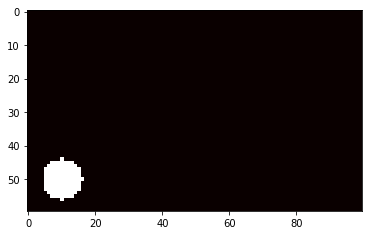



time: 910 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [54.16195 87.64584]
simu:  [25.5        42.05357143]
real:  [54.16195 87.64584]
simu:  [25.5        42.05357143]


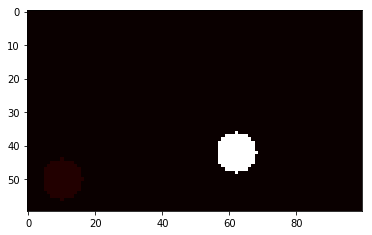



483
time: 908 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE


C:\Users\shada\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shada\Anaconda3\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


real:  [nan nan]
simu:  [50.         10.05357143]


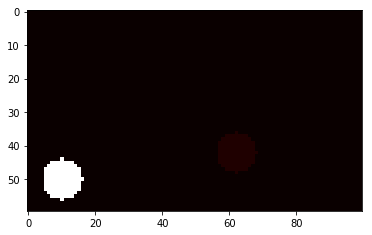



time: 908 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


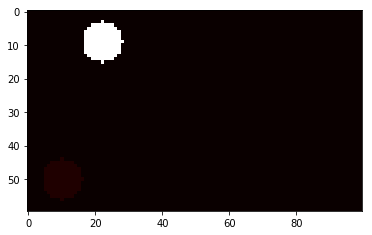



482
time: 906 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]
real:  [nan nan]
simu:  [50.         10.05357143]


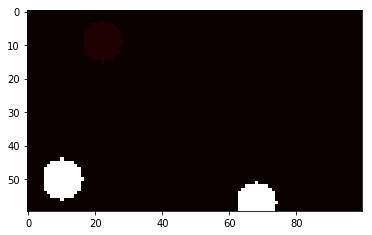



time: 906 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


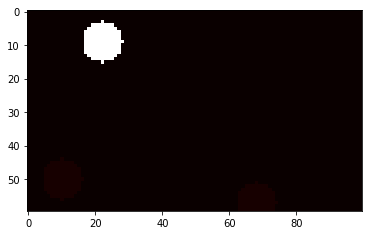



481
time: 904 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


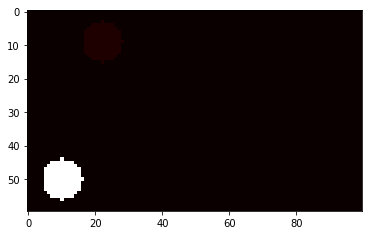



time: 904 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


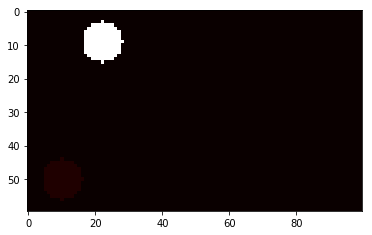



480
time: 902 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


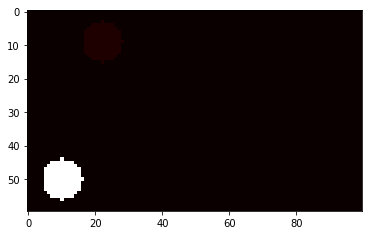



time: 902 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


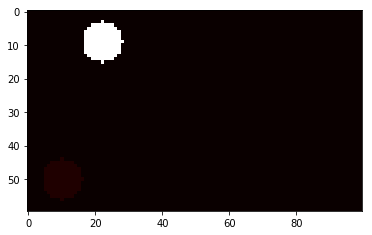



479
time: 900 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


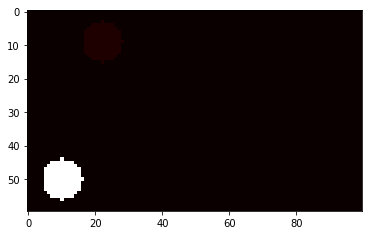



time: 900 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


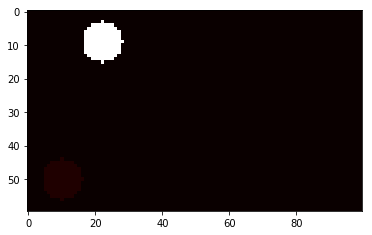



478
time: 898 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


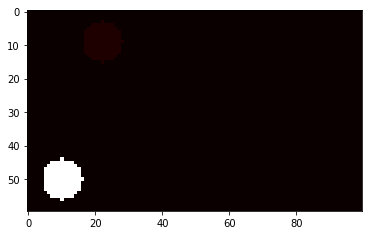



time: 898 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


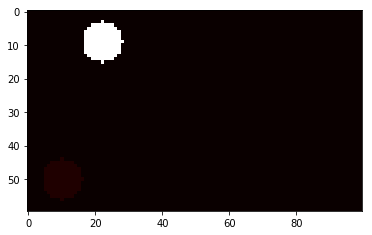



477
time: 896 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [53.92153 83.51711]
simu:  [50.         10.05357143]


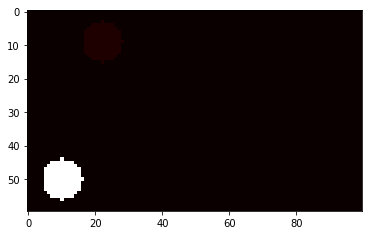



time: 896 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [53.92153 83.51711]
simu:  [ 9.         22.05357143]


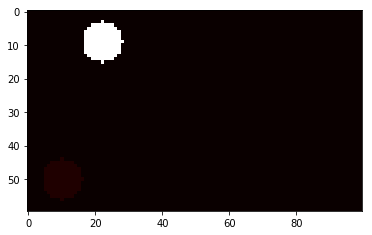



476
time: 894 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [53.45942 73.51594]
simu:  [50.         10.05357143]


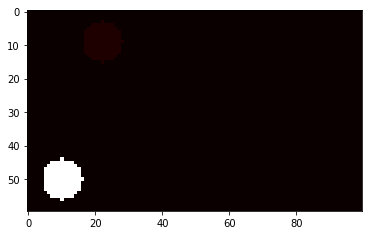



time: 894 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [53.45942 73.51594]
simu:  [ 9.         22.05357143]


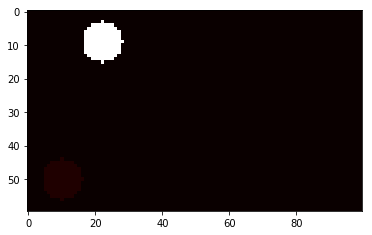



475
time: 892 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [54.67742 63.59179]
simu:  [50.         10.05357143]


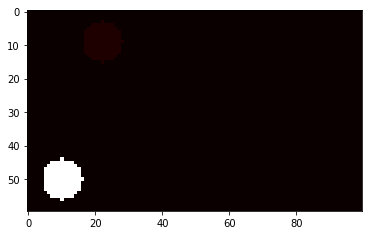



time: 892 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [54.67742 63.59179]
simu:  [ 9.         22.05357143]


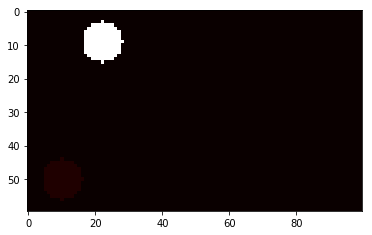



474
time: 890 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [57.     55.6933]
simu:  [50.         10.05357143]


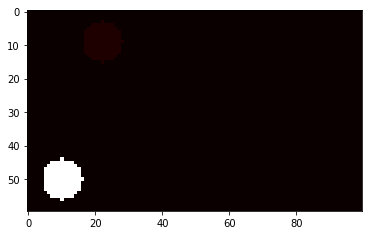



time: 890 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [57.     55.6933]
simu:  [ 9.         22.05357143]


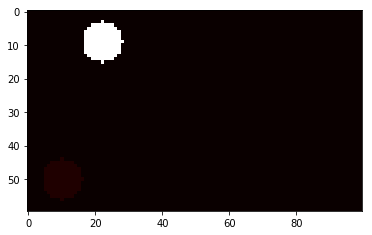



473
time: 888 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [54.2     46.45807]
simu:  [50.         10.05357143]


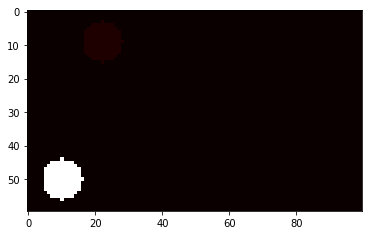



time: 888 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [54.2     46.45807]
simu:  [ 9.         22.05357143]


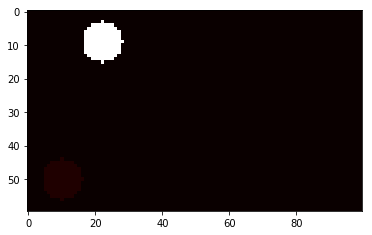



472
time: 886 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [54.26003 36.50895]
simu:  [ 9.         22.05357143]


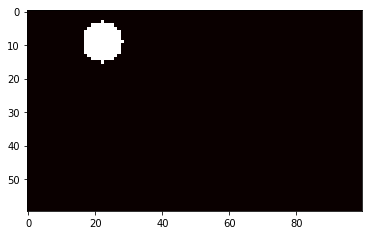



471
time: 884 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [54.77694 26.46886]
simu:  [ 9.         22.05357143]


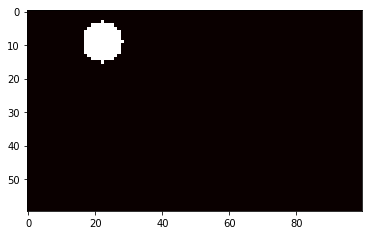



470
time: 882 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [55.27221 16.39842]
simu:  [ 9.         22.05357143]


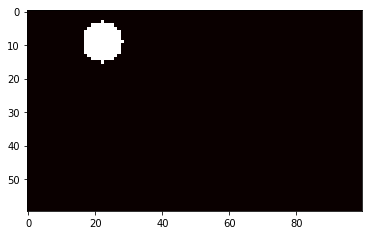



469
time: 881 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [55.4 13.8]
simu:  [ 9.         22.05357143]


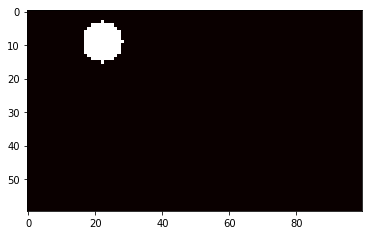



468
time: 879 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


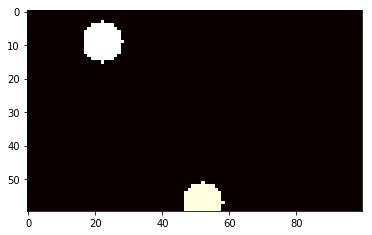



467
time: 877 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


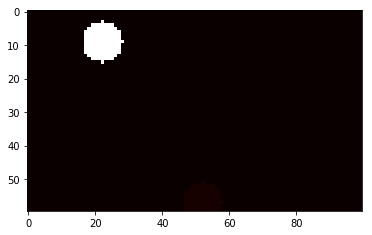



466
time: 875 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


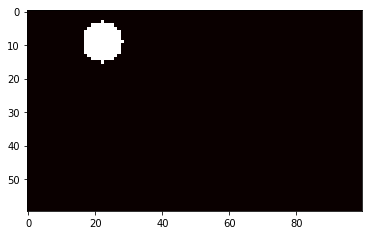



465
time: 874 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [55.41316 18.39999]
simu:  [ 9.         22.05357143]


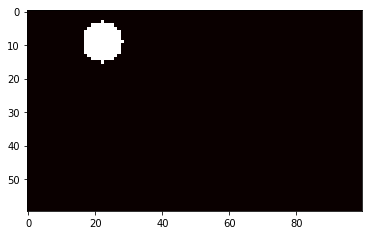



464
time: 872 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [55.50382 25.28981]
simu:  [ 9.         22.05357143]


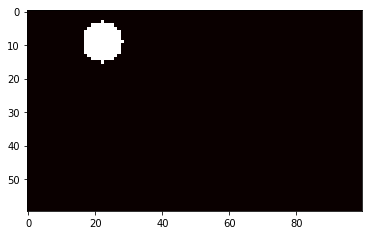



463
time: 870 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


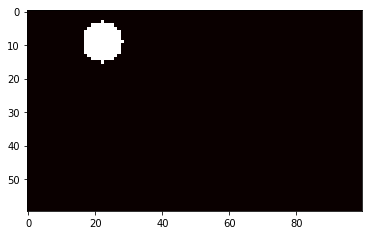



462
time: 868 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


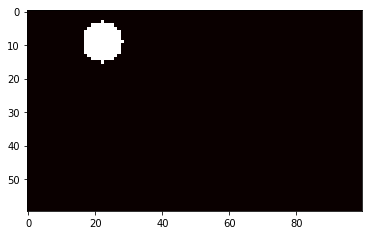



461
time: 868 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [55.41366 26.18043]
simu:  [ 9.         22.05357143]


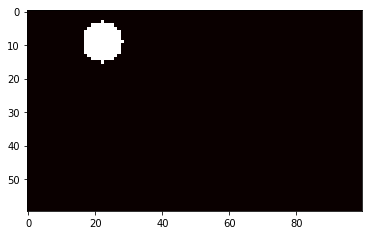



460
time: 866 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [54.46436 35.55918]
simu:  [ 9.         22.05357143]
real:  [54.46436 35.55918]
simu:  [ 9.         22.05357143]


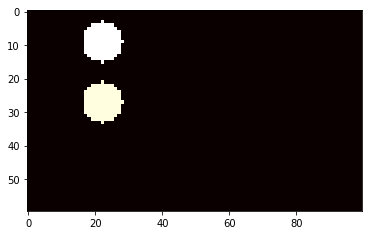



459
time: 864 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [54.18894 45.59551]
simu:  [50.         10.05357143]


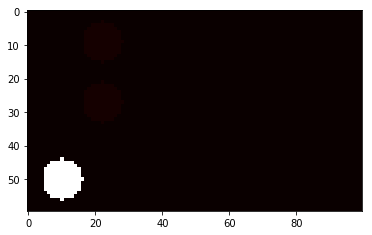



time: 864 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [54.18894 45.59551]
simu:  [ 9.         22.05357143]


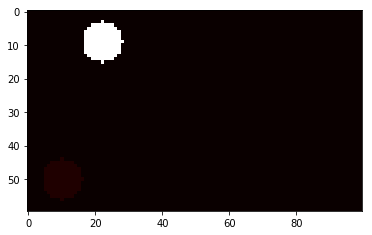



458
time: 862 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [57.00651 55.05398]
simu:  [50.         10.05357143]


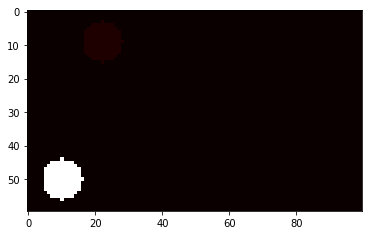



time: 862 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [57.00651 55.05398]
simu:  [ 9.         22.05357143]


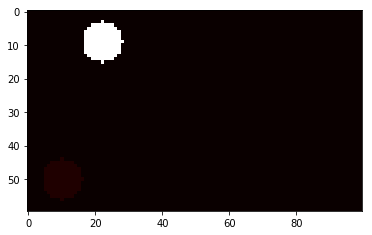



457
time: 860 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [54.60673 63.9059 ]
simu:  [50.         10.05357143]


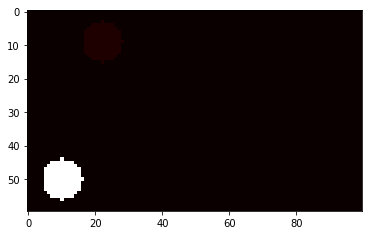



time: 860 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [54.60673 63.9059 ]
simu:  [ 9.         22.05357143]


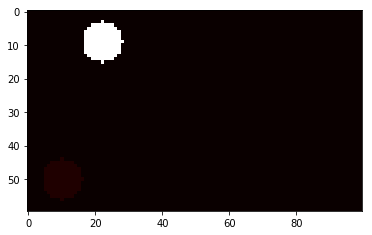



456
time: 858 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [53.47182 73.81641]
simu:  [50.         10.05357143]


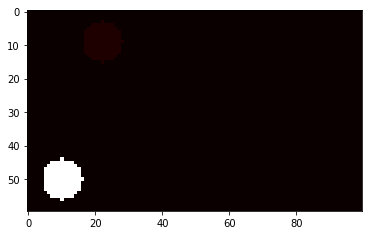



time: 858 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [53.47182 73.81641]
simu:  [ 9.         22.05357143]


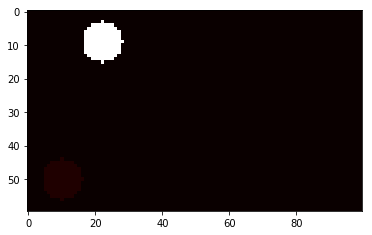



455
time: 856 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [53.9338  83.82074]
simu:  [50.         10.05357143]


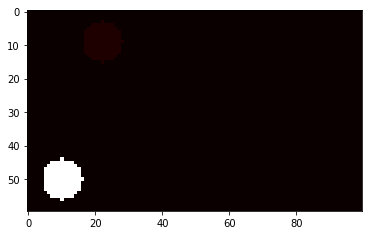



time: 856 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [53.9338  83.82074]
simu:  [ 9.         22.05357143]


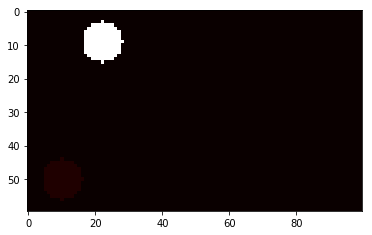



454
time: 854 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


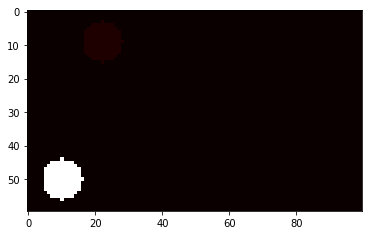



time: 854 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


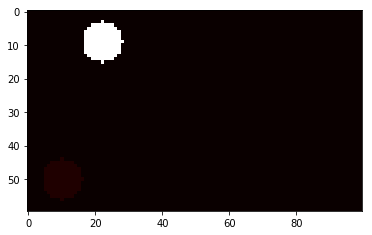



453
time: 852 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


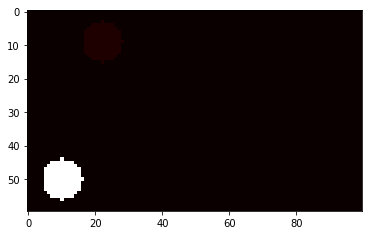



time: 852 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


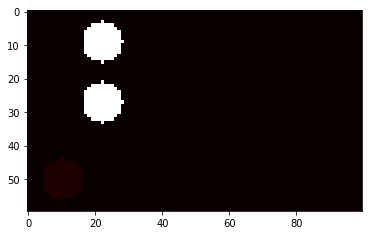



452
time: 850 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


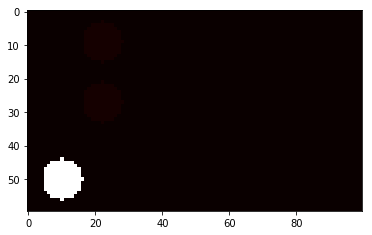



time: 850 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


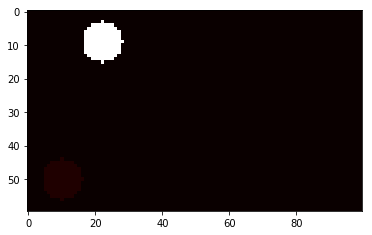



451
time: 848 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


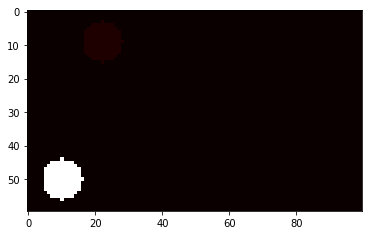



time: 848 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


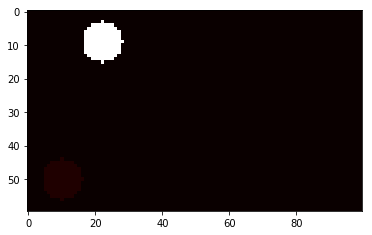



450
time: 846 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


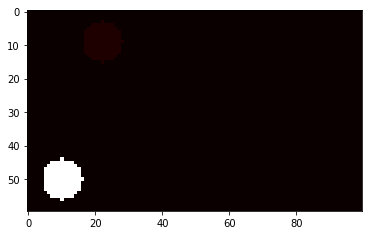



time: 846 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]
real:  [nan nan]
simu:  [ 9.         22.05357143]


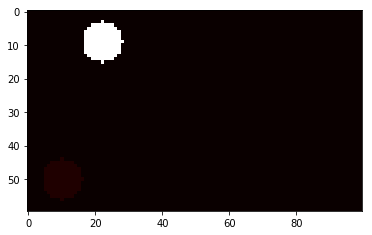



449
time: 844 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


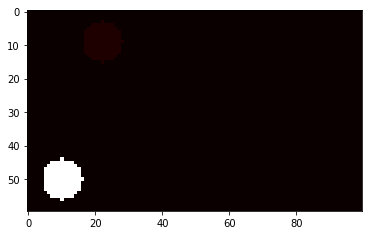



time: 844 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


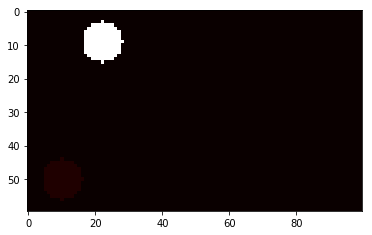



448
time: 842 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


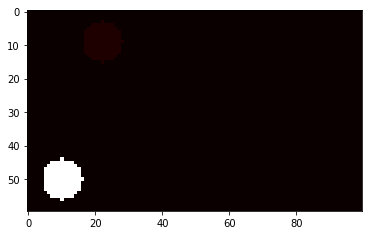



time: 842 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


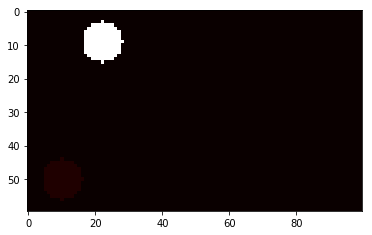



447
time: 841 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [52.60331 84.5117 ]
simu:  [50.         10.05357143]
real:  [52.60331 84.5117 ]
simu:  [50.         10.05357143]


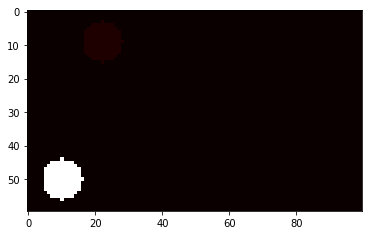



time: 841 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [52.60331 84.5117 ]
simu:  [ 9.         22.05357143]


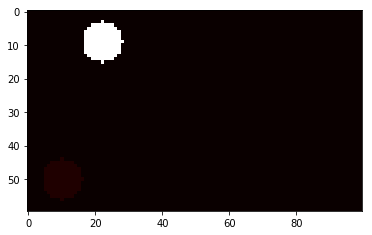



446
time: 839 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [48.14319 75.54321]
simu:  [50.         10.05357143]


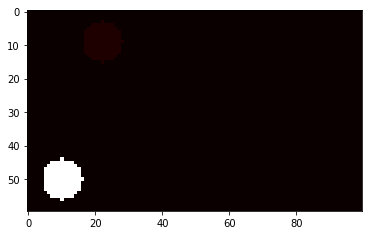



time: 839 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [48.14319 75.54321]
simu:  [ 9.         22.05357143]


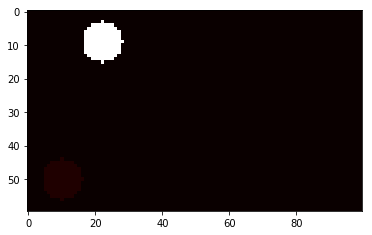



445
time: 837 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [43.66533 66.53905]
simu:  [50.         10.05357143]


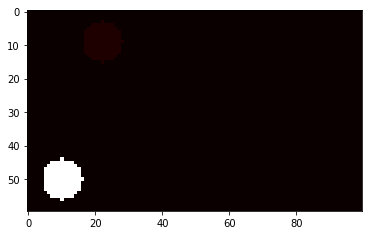



time: 837 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [43.66533 66.53905]
simu:  [ 9.         22.05357143]


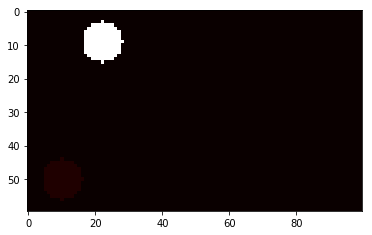



444
time: 836 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [41.8 61.6]
simu:  [50.         10.05357143]


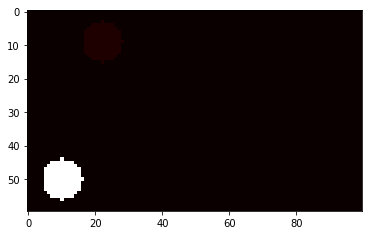



time: 836 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [41.8 61.6]
simu:  [ 9.         22.05357143]


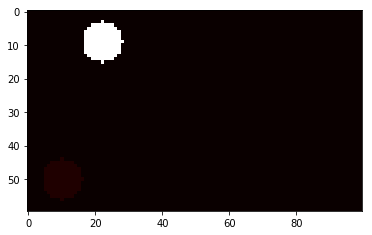



443
time: 834 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


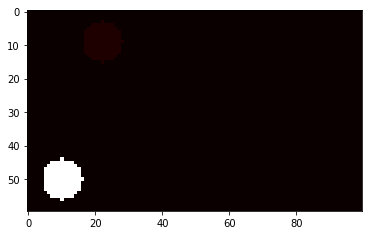



time: 834 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


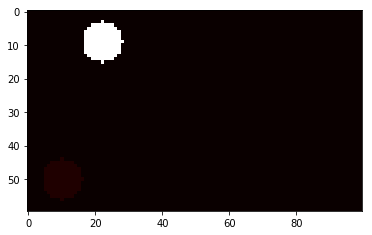



442
time: 832 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


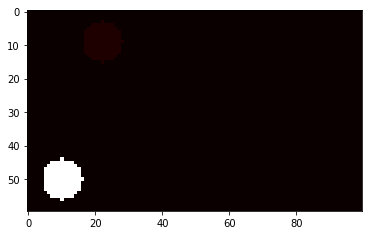



time: 832 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


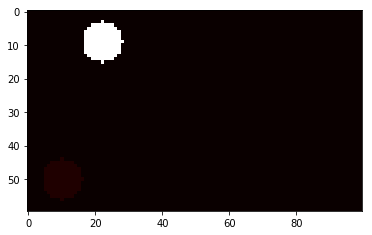



441
time: 830 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


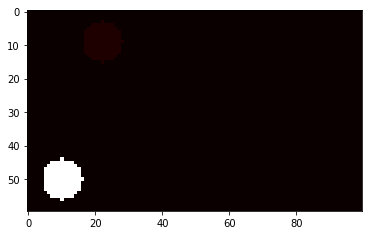



time: 830 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


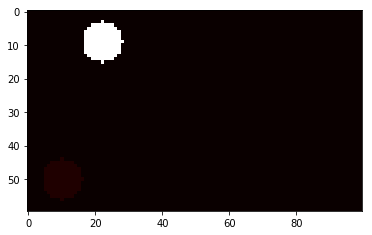



440
time: 829 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [39.79625 61.638  ]
simu:  [50.         10.05357143]


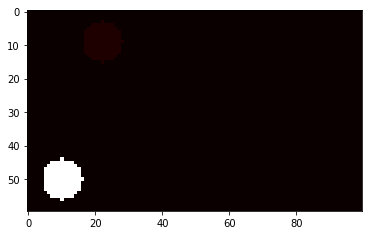



time: 829 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [39.79625 61.638  ]
simu:  [ 9.         22.05357143]


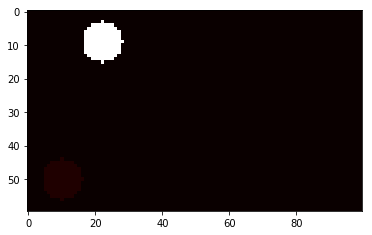



439
time: 827 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [34.39067 55.0543 ]
simu:  [50.         10.05357143]


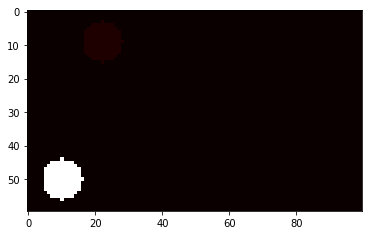



time: 827 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [34.39067 55.0543 ]
simu:  [ 9.         22.05357143]
real:  [34.39067 55.0543 ]
simu:  [ 9.         22.05357143]


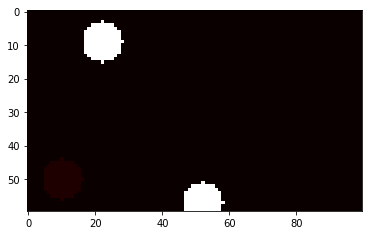



438
time: 825 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [36.81546 45.4103 ]
simu:  [50.         10.05357143]


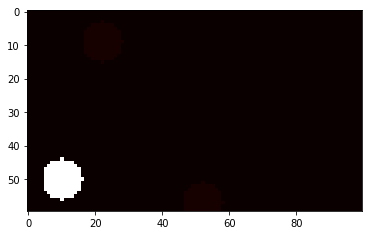



time: 825 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [36.81546 45.4103 ]
simu:  [ 9.         22.05357143]


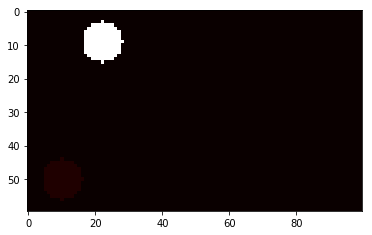



437
time: 823 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [39.07589 35.69822]
simu:  [ 9.         22.05357143]


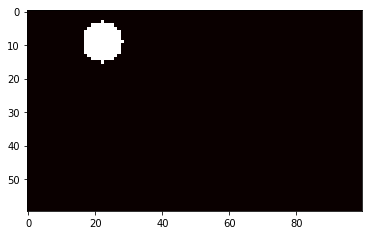



436
time: 821 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [39.94289 25.6851 ]
simu:  [ 9.         22.05357143]


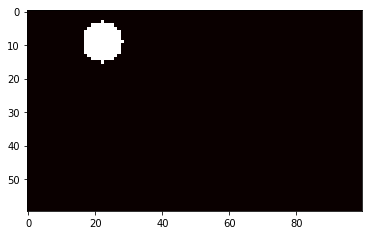



435
time: 820 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [40.      25.02968]
simu:  [ 9.         22.05357143]


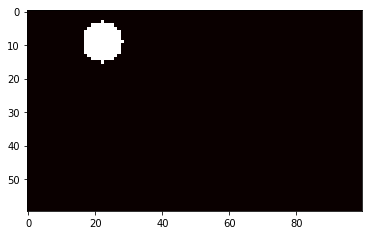



434
time: 818 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


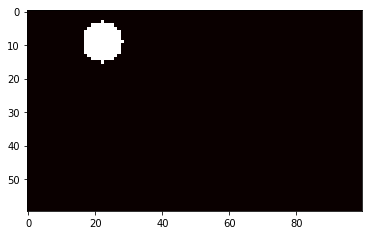



433
time: 816 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


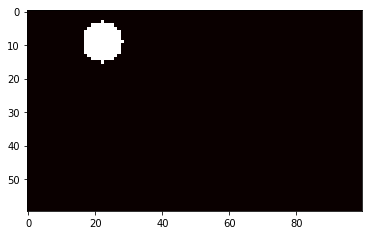



432
time: 814 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


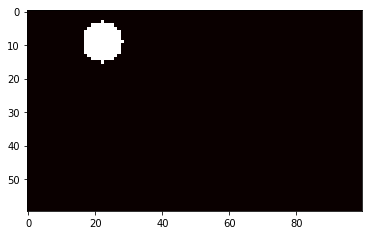



431
time: 812 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


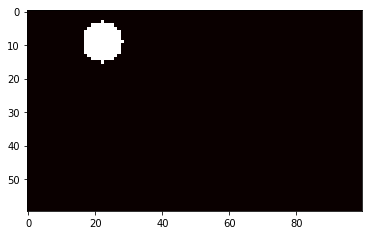



430
time: 810 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


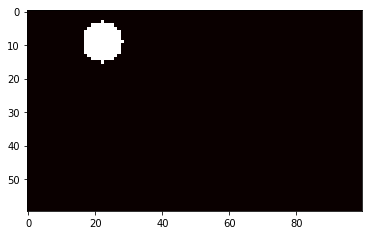



429
time: 808 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


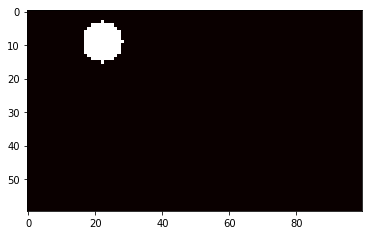



428
time: 806 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [40.46616 31.45288]
simu:  [ 9.         22.05357143]


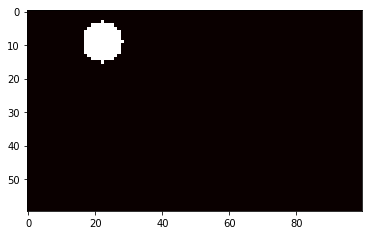



427
time: 804 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [46.5315  39.43155]
simu:  [ 9.         22.05357143]


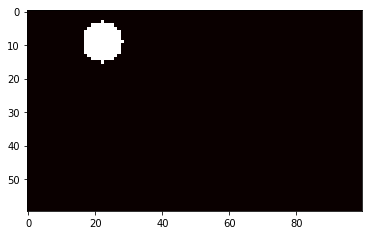



426
time: 802 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [52.61225 47.38115]
simu:  [50.         10.05357143]


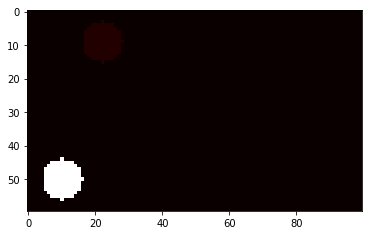



time: 802 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [52.61225 47.38115]
simu:  [ 9.         22.05357143]


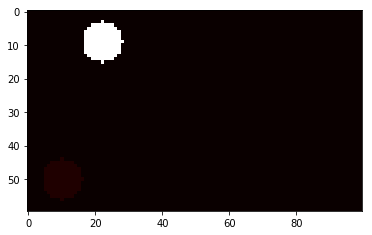



425
time: 800 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [57.02792 55.93639]
simu:  [50.         10.05357143]


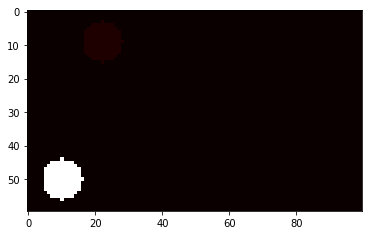



time: 800 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [57.02792 55.93639]
simu:  [ 9.         22.05357143]


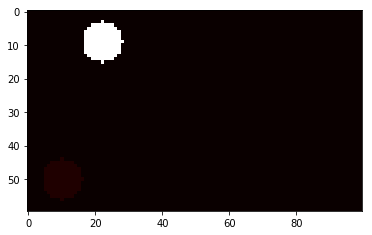



424
time: 798 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [54.36257 64.68506]
simu:  [50.         10.05357143]


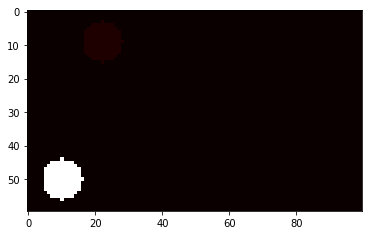



time: 798 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [54.36257 64.68506]
simu:  [ 9.         22.05357143]


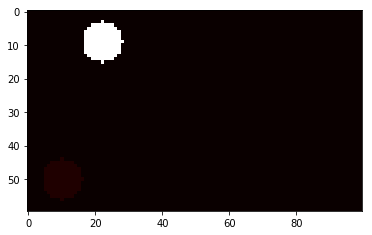



423
time: 796 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [53.50653 74.61338]
simu:  [50.         10.05357143]


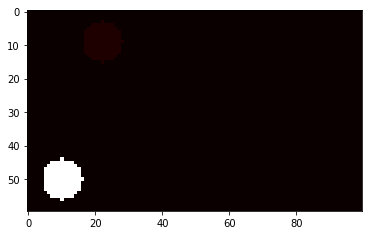



time: 796 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [53.50653 74.61338]
simu:  [ 9.         22.05357143]


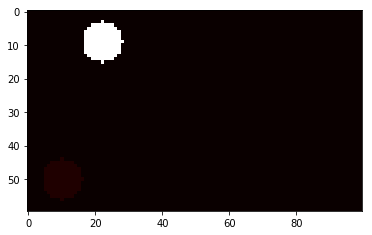



422
time: 794 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [53.9829  84.65219]
simu:  [50.         10.05357143]


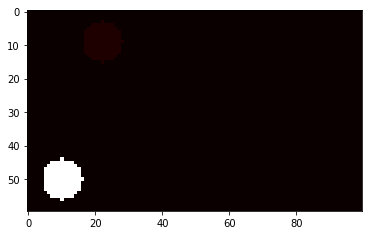



time: 794 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [53.9829  84.65219]
simu:  [ 9.         22.05357143]


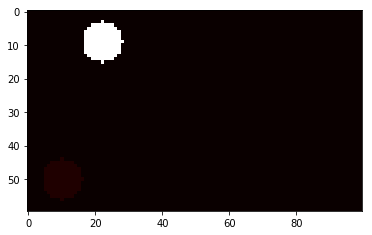



421
time: 793 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


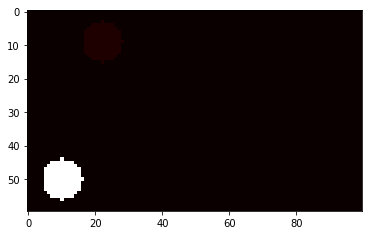



time: 793 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


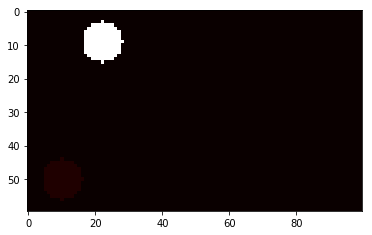



420
time: 791 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


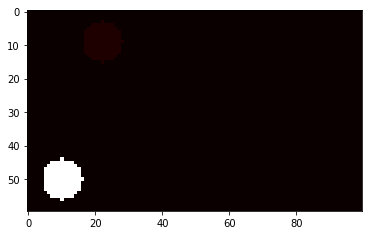



time: 791 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


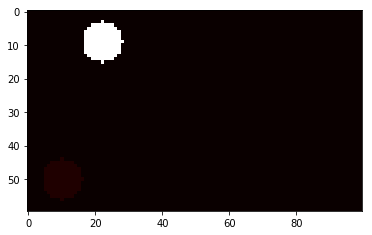



419
time: 789 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


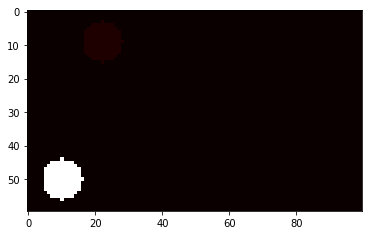



time: 789 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


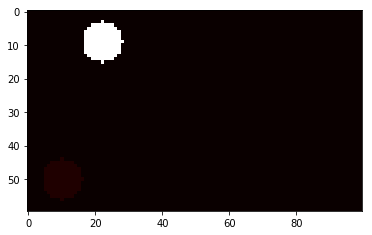



418
time: 787 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


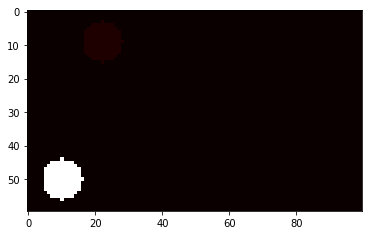



time: 787 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


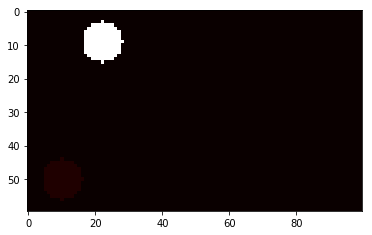



417
time: 785 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


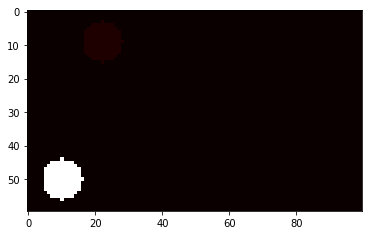



time: 785 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


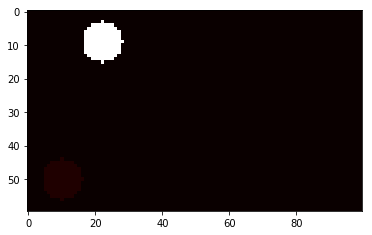



416
time: 783 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


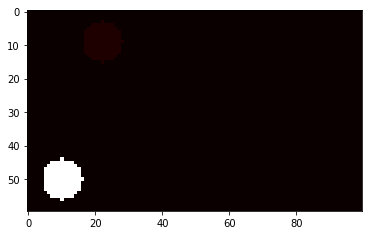



time: 783 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


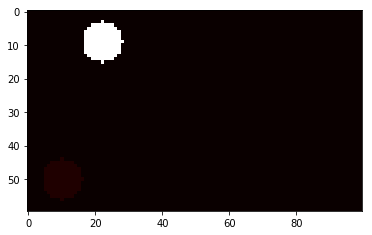



415
time: 781 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


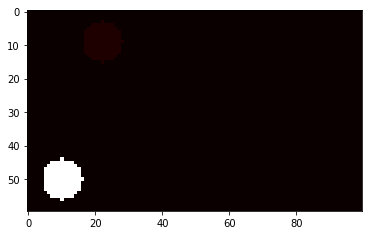



time: 781 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


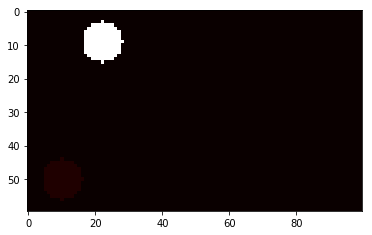



414
time: 780 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [52.29674 83.89503]
simu:  [50.         10.05357143]


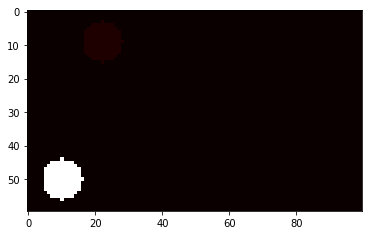



time: 780 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [52.29674 83.89503]
simu:  [ 9.         22.05357143]


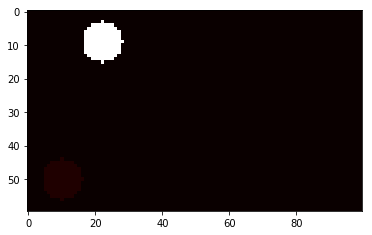



413
time: 778 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [47.8006  74.85366]
simu:  [50.         10.05357143]


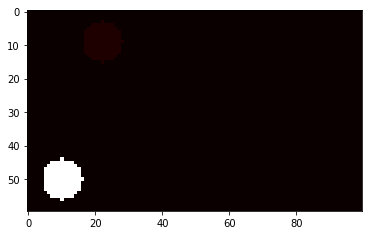



time: 778 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [47.8006  74.85366]
simu:  [ 9.         22.05357143]


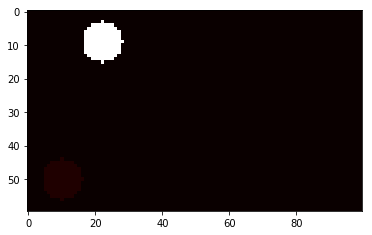



412
time: 776 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [43.31492 65.83327]
simu:  [50.         10.05357143]


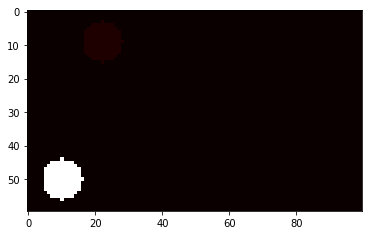



time: 776 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [43.31492 65.83327]
simu:  [ 9.         22.05357143]


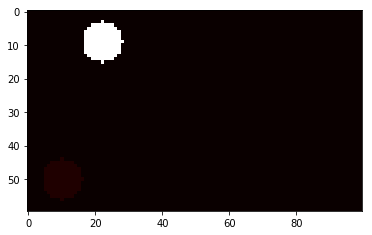



411
time: 775 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


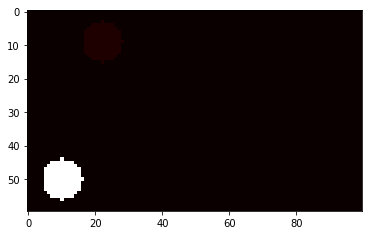



time: 775 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


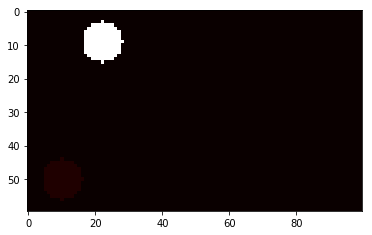



410
time: 773 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


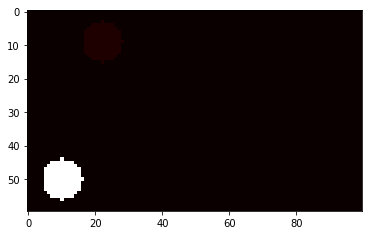



time: 773 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


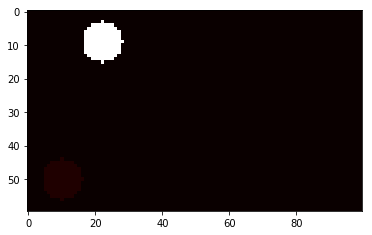



409
time: 771 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


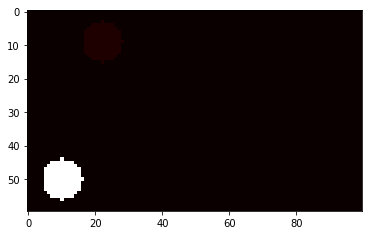



time: 771 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


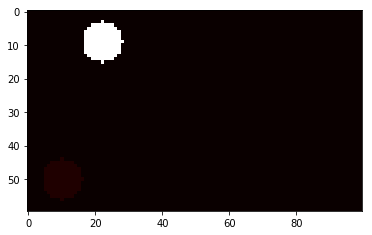



408
time: 769 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [50.         10.05357143]


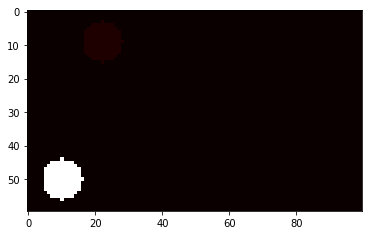



time: 769 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE
real:  [nan nan]
simu:  [ 9.         22.05357143]


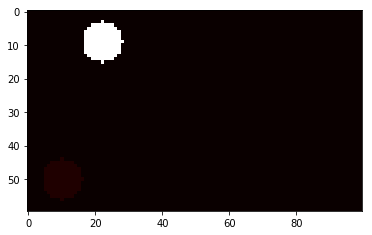



407
time: 768 --> sensor: <sensor3>, sensor type: MotionSensorBinary data: TRUE
real:  [40.53238 63.91424]
simu:  [50.         10.05357143]


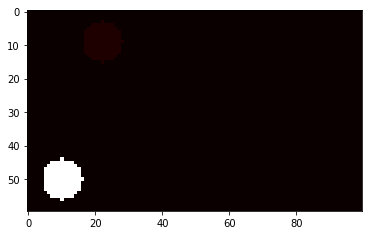



time: 768 --> sensor: <sensor6>, sensor type: MotionSensorBinary data: TRUE


KeyboardInterrupt: 

In [55]:
readFileCSV()

In [ ]:
print("please start simulation in casi now.")

In [ ]:
aa = [[0.8, 0], [0, 0]]
print(aa)
# print(*np.where(aa == np.max(aa)))
print(list(zip(*np.where(aa == np.max(aa)))))
np.mean(list(zip(*np.where(aa == np.max(aa)))), axis = 0)